### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
df = pd.read_pickle("../data/clean_data/CA_full_data_filtered.pkl")

data = df.TXT.values.tolist()


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['temperature', 'error', 'correction', 'method', 'for', 'surface', 'air', 'temperature', 'data', 'climate', 'change', 'computational', 'fluid', 'dynamics', 'correction', 'method', 'neural', 'network', 'algorithm', 'temperature', 'data', 'temperature', 'error', 'in', 'climate', 'change', 'research', 'accurate', 'temperature', 'data', 'are', 'often', 'demanded', 'however', 'affected', 'by', 'many', 'factors', 'especially', 'solar', 'radiation', 'the', 'accuracy', 'of', 'environmental', 'air', 'temperature', 'measurement', 'can', 'be', 'greatly', 'reduced', 'since', 'there', 'is', 'difference', 'in', 'temperature', 'between', 'the', 'environmental', 'air', 'and', 'the', 'related', 'temperature', 'measured', 'by', 'the', 'sensor', 'accommodated', 'inside', 'the', 'radiation', 'shield', 'in', 'the', 'paper', 'the', 'term', 'temperature', 'error', 'refers', 'to', 'the', 'temperature', 'difference', 'described', 'above', 'to', 'improve', 'the', 'accuracy', 'of', 'the', 'temperature', 'data',

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['temperature', 'error_correction', 'method', 'for', 'surface', 'air_temperature', 'data', 'climate_change', 'computational_fluid_dynamics', 'correction_method', 'neural_network_algorithm', 'temperature', 'data', 'temperature', 'error', 'in', 'climate_change', 'research', 'accurate', 'temperature', 'data', 'are_often', 'demanded', 'however', 'affected_by', 'many', 'factors', 'especially', 'solar_radiation', 'the', 'accuracy', 'of', 'environmental', 'air_temperature', 'measurement', 'can_be', 'greatly', 'reduced', 'since', 'there_is', 'difference', 'in', 'temperature', 'between', 'the', 'environmental', 'air', 'and', 'the', 'related', 'temperature', 'measured', 'by', 'the', 'sensor', 'accommodated', 'inside', 'the', 'radiation', 'shield', 'in', 'the', 'paper', 'the', 'term', 'temperature', 'error', 'refers_to_the', 'temperature', 'difference', 'described', 'above', 'to_improve', 'the', 'accuracy', 'of', 'the', 'temperature', 'data', 'temperature', 'error_correction', 'method', 'is', 'pr

### Spacy stopwords are better
We update the stopwords set with the most common words that are irrelevant for the LDA.

In [91]:
# spacy stopwords
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
print(len(all_stopwords))
all_stopwords.update(["use","uses", "used" "model", "models", "system","systems", "base","based","bases" "high", "index","approach", 
                      "information", "datum", "basis", "process", "tool","new", "problem", "result", "results", "ressource", 
                      "method", "image", "study", "feature", "technique", "different", "test", "low", "low", "class", "analysis", 
                      "paper", "provide", "provides", "provided", "data", "increase", "increases", "increased", "propose", "proposes",
                     "proposed", "feature", "features", "big", "level", 'object', "levels", "objects", "method","methods",
                     "modelled", "modeled", "modelling", "modeling", "large", "case", "cases", "present", "presents", "consider",
                     "considering", "considered", "prediction", "predicts", "predict", "predicted", "compare", "compares", "compared",
                     "comparing", "improve", "improves", "improving", "improved", "estimate", "estimating", "estimates", "estimated", 
                     "network", "networks", "control", "controls", "controlled", "controlling", "include", "includes", "including",
                     "included", "show", "shows", "showed", "showing", "important", "high", "develop", "develops", "developed", "developing",
                     "change", "changes", "changed", "changing", "performance", "apply", "applies", "applied", "applying",
                     "observe", "observes", "observing", "observed", "lean", "learns", "learned", "value", "obtain", "obtained",
                     "obtains", "obtained", "indicate", "indicates", "indicating","indicated", "application", "applications"])
print(len(all_stopwords))

442
448


In [92]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [174]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

In [177]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

In [176]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]



[[('accommodate', 1),
  ('accuracy', 3),
  ('accurate', 1),
  ('accurately', 2),
  ('add', 1),
  ('adopt', 1),
  ('affected', 1),
  ('air', 1),
  ('calculate', 1),
  ('climate', 2),
  ('computational_fluid_dynamic', 2),
  ('continuously', 1),
  ('correction', 4),
  ('correction_equation', 1),
  ('correspond', 2),
  ('degree', 1),
  ('degrees_respectively', 2),
  ('demand', 1),
  ('describe', 1),
  ('determine', 1),
  ('difference', 2),
  ('dtr', 1),
  ('environmental', 2),
  ('environmental_factor', 1),
  ('error', 8),
  ('especially', 1),
  ('experiment', 1),
  ('experimentally', 1),
  ('factor', 1),
  ('factors_influence', 1),
  ('field', 1),
  ('finally', 1),
  ('fitting', 1),
  ('form', 1),
  ('furtherly', 1),
  ('greatly', 1),
  ('inside', 1),
  ('measure', 1),
  ('measurement', 1),
  ('neural', 1),
  ('observation', 1),
  ('perform', 1),
  ('quantify', 1),
  ('radiation', 2),
  ('reduce', 2),
  ('refer', 1),
  ('relate', 1),
  ('research', 1),
  ('root_mean_square_error', 1),
  (

### Counter most common words

In [96]:
from collections import Counter

frequencies = Counter()
frequencies_ngram = Counter()
stuff = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
for i, tok in enumerate(stuff):
    for tup in tok:
        if "_" in tup[0]:
            frequencies_ngram[tup[0]] += 1
        frequencies[tup[0]] +=1


print(frequencies.most_common(10))
print(frequencies["neural_network"])

[('climate', 2064), ('model', 1994), ('area', 1097), ('environmental', 1031), ('impact', 882), ('accuracy', 841), ('research', 818), ('neural', 808), ('identify', 778), ('study', 767)]
0


### Wordcloud only bigrams

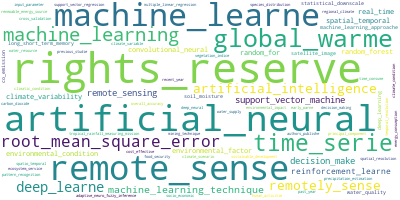

In [97]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies_ngram)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

### main wordcloud

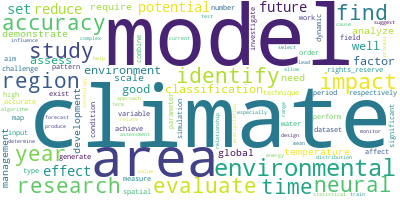

In [98]:
# Nuage de mots
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequencies)
wordcloud.to_image()
# wordcloud.to_file("img/worldcloud.png")
wordcloud.to_image()

### Looking for the most coherent number of topics

In [100]:
for i in range(3,9):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    print(i, "=", coherence_model_lda.get_coherence())

3 = 0.3991852912933472
4 = 0.3370839882882002
5 = 0.3564642006311193
6 = 0.360694951605023
7 = 0.3631381615273492
8 = 0.3530247296120256


In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"classification" + 0.014*"area" + 0.010*"map" + 0.008*"land" + '
  '0.007*"soil" + 0.006*"detection" + 0.006*"forest" + 0.005*"spatial" + '
  '0.005*"specie" + 0.005*"image"'),
 (1,
  '0.023*"model" + 0.019*"climate" + 0.010*"neural" + 0.007*"value" + '
  '0.007*"temperature" + 0.006*"precipitation" + 0.006*"area" + '
  '0.005*"forecast" + 0.005*"forecasting" + 0.005*"period"'),
 (2,
  '0.012*"environmental" + 0.009*"learn" + 0.008*"adaptive" + 0.008*"learning" '
  '+ 0.007*"environment" + 0.007*"management" + 0.006*"sensor" + '
  '0.006*"social" + 0.006*"energy" + 0.005*"strategy"')]


In [104]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.142686470445698

Coherence Score:  0.3991852912933472


In [106]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, '../html/3topics_CA.html')
vis

/home/kevin-main/anaconda3/envs/datascience/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.120511  0.147582       1        1  39.726161
2     -0.202904  0.019718       2        1  34.214465
0      0.082393 -0.167300       3        1  26.059374, topic_info=                Term         Freq        Total Category  logprob  loglift
680   classification  1842.000000  1842.000000  Default  30.0000  30.0000
208            model  4410.000000  4410.000000  Default  29.0000  29.0000
382              map  1084.000000  1084.000000  Default  28.0000  28.0000
876            learn  1259.000000  1259.000000  Default  27.0000  27.0000
57              area  2410.000000  2410.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1           accuracy   337.646652  1043.904552   Topic3  -5.7369   0.2161
388           sample   278.648017   568.392788   Topic3  -5.9290   0.6319
1402     environment   294.229170  1289.125897   Topic3  -5.8745  -0.1326
1356       potential   276.714863   846.267457   Topic3  -5.9359   0.2269
548            study   264.279945   929.097152   Topic3  -5.9819   0.0876

[202 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.613083  accuracy
1         2  0.063224  accuracy
1         3  0.323784  accuracy
1675      2  0.998851  adaptive
2313      2  0.998276     agent
...     ...       ...       ...
2773      3  0.998560   wetland
1473      1  0.997623      wind
306       1  0.803566      year
306       2  0.032339      year
306       3  0.164633      year

[288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [160]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = list(row)[0]
        row = sorted(row, key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8676,"model, climate, neural, value, temperature, pr...",Temperature error-correction method for surfac...
1,1,1.0,0.5538,"model, climate, neural, value, temperature, pr...",Ensemble Machine Learning Approach Improves Pr...
2,2,2.0,0.8709,"environmental, learn, adaptive, learning, envi...",OPEN SCIENCE AND ARTIFICIAL INTELLIGENCE SUPPO...
3,3,1.0,0.7418,"model, climate, neural, value, temperature, pr...",Contiguous US surface water availability and s...
4,4,1.0,0.4794,"model, climate, neural, value, temperature, pr...",No perfect storm for crop yield failure in Ger...
...,...,...,...,...,...
4400,4400,2.0,0.9907,"environmental, learn, adaptive, learning, envi...",The effect of social learning in a small popul...
4401,4401,2.0,0.9877,"environmental, learn, adaptive, learning, envi...",Transfer Learning for Performance Modeling of ...
4402,4402,1.0,0.7447,"model, climate, neural, value, temperature, pr...",Forecasting the spatiotemporal variability of ...
4403,4403,2.0,0.9909,"environmental, learn, adaptive, learning, envi...",Strategies for sustainable management of renew...


In [161]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorted = sent_topics_sorted.set_index("Topic_Num")
# Show
sent_topics_sorted.head(8)


,Topic_Perc_Contrib,Keywords,Text
Topic_Num,,,
0.0,0.9770,"classification, area, map, land, soil, detecti...",Physicochemical Drivers of Microbial Community...
1.0,0.9931,"model, climate, neural, value, temperature, pr...",The drought trend and its relationship with ra...
2.0,0.9945,"environmental, learn, adaptive, learning, envi...",A playwriting technique to engage on a shared ...


In [162]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts*100/topic_counts.sum(), 4)
topic_counts

sent_topics_sorted = sent_topics_sorted.merge(topic_counts, how = "left", left_index=True, right_index = True)
sent_topics_sorted = sent_topics_sorted.merge(topic_contribution, how = "left", left_index = True, right_index = True)
sent_topics_sorted = sent_topics_sorted.rename(columns={"Dominant_Topic_x": "Articles", "Dominant_Topic_y": "Percentage"})
sent_topics_sorted

,Topic_Perc_Contrib,Keywords,Text,Articles,Percentage
Topic_Num,,,,,
0.0,0.9770,"classification, area, map, land, soil, detecti...",Physicochemical Drivers of Microbial Community...,1087,24.6765
1.0,0.9931,"model, climate, neural, value, temperature, pr...",The drought trend and its relationship with ra...,1828,41.4983
2.0,0.9945,"environmental, learn, adaptive, learning, envi...",A playwriting technique to engage on a shared ...,1490,33.8252


In [163]:
for i,j in sent_topics_sorted.Keywords.items():
    print(i,j)

0.0 classification, area, map, land, soil, detection, forest, spatial, specie, image
1.0 model, climate, neural, value, temperature, precipitation, area, forecast, forecasting, period
2.0 environmental, learn, adaptive, learning, environment, management, sensor, social, energy, strategy


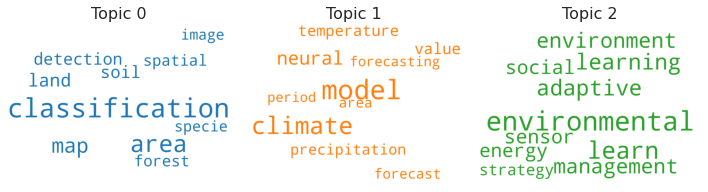

In [164]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=all_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Adding titles of topics and merging the topics on the original dataframe

In [165]:
# Dictionary to title the topics
# 0 = biggest number on the html representation

dic_of_topic = {0:"Land and Forests", 1:"Rain and temperature forecast", 2:"Energy management"}
df_dominant_topic["Topic"] = df_dominant_topic["Dominant_Topic"].apply(lambda x: dic_of_topic[x])

result = pd.concat([df.reset_index(drop=True), df_dominant_topic.Dominant_Topic,df_dominant_topic.Topic,  df_dominant_topic.Keywords], axis=1)
result

,PT,AU,TI,LA,DE,AB,C1,PY,CN,TXT,Dominant_Topic,Topic,Keywords
0,J,"Yang, J; Deng, X; Liu, QQ; Ding, RH",Temperature error-correction method for surfac...,English,climate change; computational fluid dynamics; ...,"In climate change research, accurate temperatu...","[Yang, Jie; Deng, Xuan; Liu, Qingquan] Nanjing...",2020,"[China, China, China]",Temperature error-correction method for surfac...,1.0,Rain and temperature forecast,"model, climate, neural, value, temperature, pr..."
1,J,"Mishra, U; Gautam, S; Riley, WJ; Hoffman, FM",Ensemble Machine Learning Approach Improves Pr...,English,soil organic carbon; spatial prediction; machi...,Various approaches of differing mathematical c...,"[Mishra, Umakant; Gautam, Sagar] Sandia Natl L...",2020,"[United States, United States, United States]",Ensemble Machine Learning Approach Improves Pr...,1.0,Rain and temperature forecast,"model, climate, neural, value, temperature, pr..."
2,J,"Coro, G",OPEN SCIENCE AND ARTIFICIAL INTELLIGENCE SUPPO...,English,artificial intelligence; big data; blue growth...,The long-term EU strategy to support the susta...,"[Coro, Gianpaolo] Natl Res Council Italy ISTI ...",2020,[Italy],OPEN SCIENCE AND ARTIFICIAL INTELLIGENCE SUPPO...,2.0,Energy management,"environmental, learn, adaptive, learning, envi..."
3,J,"Siddiqui, S; Conkle, JL; Sadovski, A",Contiguous US surface water availability and s...,English,Wastewater treatment plant effluent flow model...,Surface water is a vital and sometimes stresse...,"[Siddiqui, Samreen; Conkle, Jeremy L.] Texas A...",2020,"[United States, United States]",Contiguous US surface water availability and s...,1.0,Rain and temperature forecast,"model, climate, neural, value, temperature, pr..."
4,J,"Webber, H; Lischeid, G; Sommer, M; Finger, R; ...",No perfect storm for crop yield failure in Ger...,English,crop yield failure; extreme events; support ve...,Large-scale crop yield failures are increasing...,"[Webber, Heidi; Lischeid, Gunnar; Sommer, Mich...",2020,"[Germany, Germany, Germany, Switzerland, Germany]",No perfect storm for crop yield failure in Ger...,1.0,Rain and temperature forecast,"model, climate, neural, value, temperature, pr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,J,"Romero-Mujalli, D; Cappelletto, J; Herrera, EA...",The effect of social learning in a small popul...,English,Learning; Social learning; Agent-based simulat...,Learning is defined as behavioral modification...,"[Romero-Mujalli, Daniel; Tarano, Zaida] Cent U...",2017,"[Venezuela, Venezuela, Venezuela, Germany]",The effect of social learning in a small popul...,2.0,Energy management,"environmental, learn, adaptive, learning, envi..."
4401,C,"Jamshidi, P; Siegmund, N; Velez, M; Kastner, C...",Transfer Learning for Performance Modeling of ...,English,Performance analysis; transfer learning,Modern software systems provide many configura...,"[Jamshidi, Pooyan; Velez, Miguel; Kaestner, Ch...",2017,"[United States, Germany]",Transfer Learning for Performance Modeling of ...,2.0,Energy management,"environmental, learn, adaptive, learning, envi..."
4402,J,"Freitas, LPS; Lopes, MLM; Carvalho, LB; Panoss...",Forecasting the spatiotemporal variability of ...,English,Neural techniques; Soil respiration; Green har...,Carbon dioxide (CO2) is considered one of the ...,"[Freitas, Luciana P. S.; Minussi, Carlos R.; L...",2018,"[Brazil, Brazil, Brazil, Brazil, Brazil]",Forecasting the spatiotemporal variability of ...,1.0,Rain and temperature forecast,"model, climate, neural, value, temperature, pr..."
4403,J,"Lindkvist, E; Ekeberg, O; Norberg, J",Strategies for sustainable management of renew...,English,natural resource management; adaptive manageme...,As a consequence of global environmental chang...,"[Lindkvist, Emilie; Norberg, Jon] Stockholm Un...",2017,"[Sweden, Sweden]",Strategies for sustainable management of renew...,2.0,Energy management,"environmental, learn, adaptive, learning, envi..."


### Grouping per year to plot

In [166]:
year_topic = result.groupby(["PY", "Topic"]).size()
year_topic = year_topic.unstack(1)
year_topic


Topic,Energy management,Land and Forests,Rain and temperature forecast
PY,,,
2010,26,29,43
2011,38,40,44
2012,52,34,56
2013,49,48,97
2014,64,47,87
2015,87,61,122
2016,128,76,145
2017,148,105,160
2018,193,157,251


### Plotting and saving in the img folder

<AxesSubplot:title={'center':'Climate action over the years, three topics'}, xlabel='PY'>

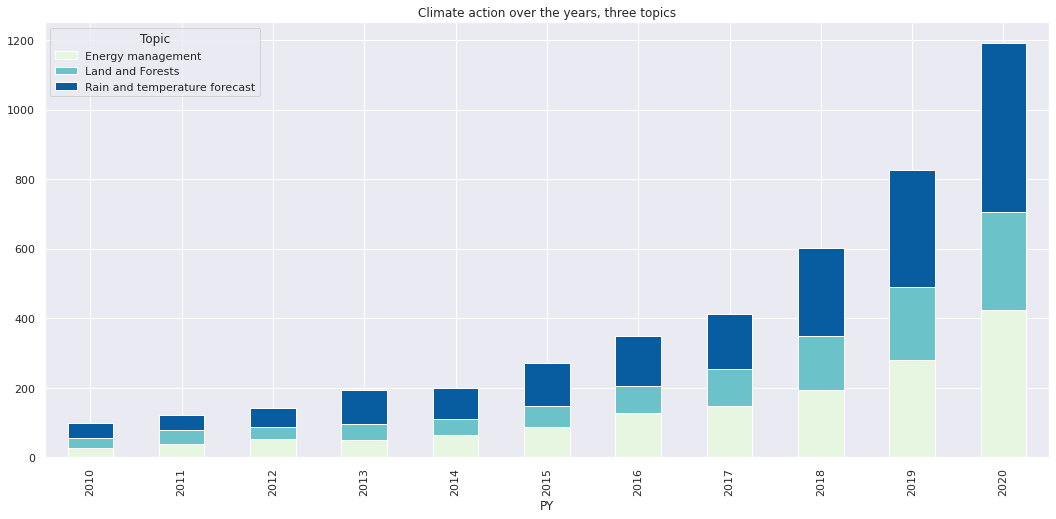

In [167]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()
gr = year_topic.transpose().T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set_title("Climate action over the years, three topics")
gr.figure.savefig("../img/CA_3topics.png")
gr

In [168]:
year_topic_percentage = result.groupby(['PY']).Topic.value_counts(normalize=True).mul(100).unstack(1).transpose()
year_topic_percentage

PY,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Topic,,,,,,,,,,,
Energy management,26.530612,31.147541,36.619718,25.257732,32.323232,32.222222,36.676218,35.835351,32.113145,33.857316,35.684299
Land and Forests,29.591837,32.786885,23.943662,24.742268,23.737374,22.592593,21.776504,25.423729,26.123128,25.392987,23.509656
Rain and temperature forecast,43.877551,36.065574,39.436620,50.000000,43.939394,45.185185,41.547278,38.740920,41.763727,40.749698,40.806045


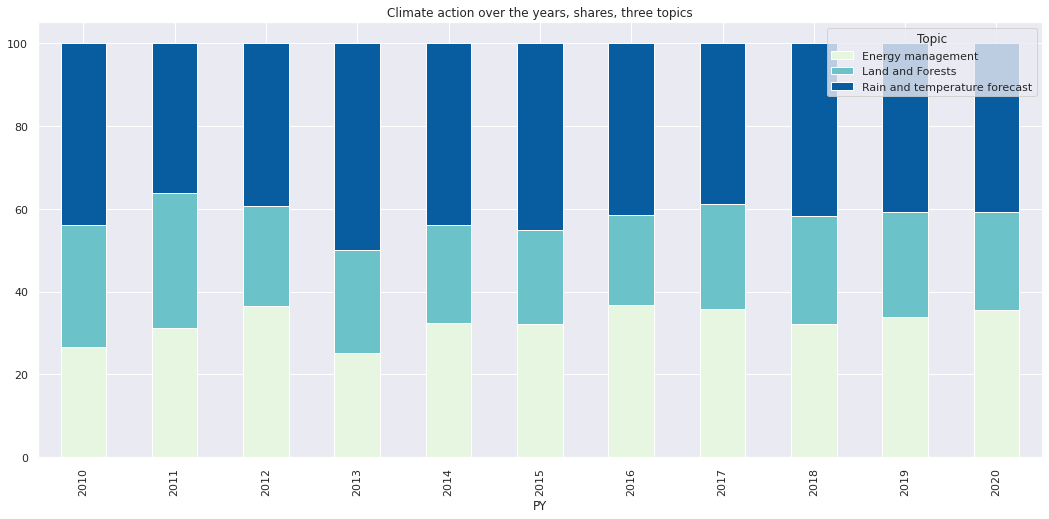

In [169]:
gr = year_topic_percentage.T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), figsize=(18,8))
gr.set(title="Climate action over the years, shares, three topics")
gr.figure.savefig("../img/CA_3topics_share.png")


### Sentiment analysis applied after the topic modelling

In [170]:
# Average sentiment analysis for each topic
import pandas as pd
import numpy as np
import nltk
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /home/kevin-
[nltk_data]     main/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Some examples

In [171]:
result['sentiment_score'] = result.TXT.apply(lambda x : sid.polarity_scores(x))
result["neg_score"] = result.sentiment_score.apply(lambda x : x['neg'])
result["neu_score"] = result.sentiment_score.apply(lambda x : x['neu'])
result["pos_score"] = result.sentiment_score.apply(lambda x : x['pos'])
result["compound_score"] = result.sentiment_score.apply(lambda x : x['compound'])

In [172]:
for ind, row in result.iterrows():
    if abs(row.compound_score) > 0.994:
        print(ind, row.TI) 
        print("Negative score: ",row.neg_score, " Positive score: ", row.pos_score, " Compound score: ", row.compound_score)
        print("Topic : ", row.Topic)
        print("---")
        print(row.AB)
        print('\n')
        

12 Energy Optimisation of Cascading Neural-network Classifiers
Negative score:  0.015  Positive score:  0.219  Compound score:  0.9951
Topic :  Energy management
---
Artificial Intelligence is increasingly being used to improve different facets of society such as healthcare, education, transport, security, etc. One of the popular building blocks for such AI systems are Neural Networks, which allow us to recognise complex patterns in large amounts of data. With the exponential growth of data, Neural Networks have become increasingly crucial to solve more and more challenging problems. As a result of this, the computational and energy requirements for these algorithms have grown immensely, which going forward will be a major contributor to climate change. In this paper, we present techniques to reduce the energy use of Neural Networks without significantly reducing their accuracy or requiring any specialised hardware. In particular, our work focuses on Cascading Neural Networks and reduc

### Mean per Topics

In [158]:
res = result.groupby("Topic")
res_mean = res.compound_score.mean()
res_mean

Topic
Energy management                0.678144
Land and Forests                 0.574783
Rain and temperature forecast    0.578447
Name: compound_score, dtype: float64

<AxesSubplot:xlabel='Topic'>

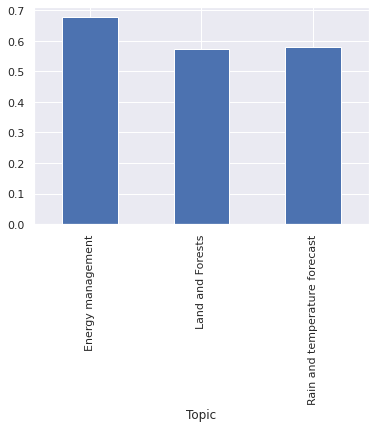

In [159]:
res.compound_score.mean().plot.bar()